
### Jupyter Notebook in VS Code

From directory with virtual environment in it, use this terminal command to use Jupyter Notebook in VS Code:

jupyter notebook --NotebookApp.allow_origin='*' --NotebookApp.ip='0.0.0.0'

### Select Python Interpreter

Open Command Palette as follows: Ctrl+Shift+P

Then select from VS Code Command Palette: "Python: Select Interpreter" and choose the same Python interpreter that you used to install Jupyter.

If server not shown, enter server manually as follows: 
http://localhost:8888

Reminder:  pw: ""

### Load Libraries and Dataset

In [1]:
# %reset

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, metrics
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
# set device to cuda if available, otherwise use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [4]:
# df = pd.read_csv('Sandbox/MovieLens/ml-latest-small/ratings.csv')

df = pd.read_pickle('combined_survey_data.pkl')

In [5]:
df.info()  # Show the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 101463 entries, 0 to 1133
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   101463 non-null  int64  
 1   movieId  101463 non-null  int64  
 2   rating   101463 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [6]:
df.userId.nunique()  # Number of unique users

624

In [7]:
df.movieId.nunique()  # Number of unique movies

9724

In [8]:
df.rating.value_counts()  # Count of each rating

rating
4.0    27051
3.0    20211
5.0    13389
3.5    13136
4.5     8551
2.0     7593
2.5     5550
1.0     2821
1.5     1791
0.5     1370
Name: count, dtype: int64

In [9]:
df.shape  # Number of rows and columns

(101463, 3)

### Class Wrapper for Training Dataset Preprocessing

In [10]:
class MovieDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            'users': torch.tensor(users, dtype=torch.long),
            'movies': torch.tensor(movies, dtype=torch.long),
            'ratings': torch.tensor(ratings, dtype=torch.long)
        }



### Create a class for the neural network model

In [11]:

# Inherit from nn.Module, the base class for neural network modules in PyTorch
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=64):
        super().__init__()

        # Embedding layers for users and movies
        # Trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, n_factors)
        self.movie_embed = nn.Embedding(n_movies, n_factors)

        # Define linear layer that takes concatenated embeddings and
        # outputs a single value (the predicted rating)
        self.out = nn.Linear(int(n_factors * 2), 1)

    def forward(self, users, movies, ratings=None):
        '''
        Pass the user and movie indices through the embedding layers
        and concatenate the embedding vectors

        Then pass the concatenated vectors through the linear layer
        to get the predicted rating
        '''
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        # Concatenate user and movie embedding vectors on dim 1, feature dim
        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)

        return output


### Encode User and Movie IDs to Sequential Numbers Starting from Zero and Create Train and Test Datasets

In [12]:
# Encode the user and movie ids to start from 0 so we don't run into index
# out of range errors while creating the embedding layers

# Create a label encoder for user and movie ids
# Label encoder assigns a unique integer to each user and movie id
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

# Encode the user and movie ids
df.userId = lbl_user.fit_transform(df.userId.to_numpy())
df.movieId = lbl_movie.fit_transform(df.movieId.to_numpy())

# Split the data into training and validation sets
# Note that random state sets a repeatable random seed
df_train, df_test = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.to_numpy()
)

# Create dataset for training
train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

# Create dataset for validation
valid_dataset = MovieDataset(
    users=df_test.userId.values,
    movies=df_test.movieId.values,
    ratings=df_test.rating.values
)

# print items in validation dataset and expand vectors for the first 5 items
for i in range(5):
    print(valid_dataset[i])


{'users': tensor(121), 'movies': tensor(6436), 'ratings': tensor(5)}
{'users': tensor(361), 'movies': tensor(659), 'ratings': tensor(5)}
{'users': tensor(447), 'movies': tensor(412), 'ratings': tensor(4)}
{'users': tensor(3), 'movies': tensor(3214), 'ratings': tensor(4)}
{'users': tensor(118), 'movies': tensor(8448), 'ratings': tensor(4)}


### Create Data Loaders for Training and Validation

In [13]:
# Create data loaders for training and validation
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(dataset=valid_dataset,
                         batch_size=4,
                         shuffle=True,
                         num_workers=2)

# Fetch a batch of data from the training loader
# Create an iterator object from the training loader
dataiter = iter(train_loader)

# Fetch the next batch of data (batch_size=4) from the iterator
dataloader_data = next(dataiter)

# Print the batch data
print(dataloader_data)


{'users': tensor([149, 317,  50, 110]), 'movies': tensor([  84, 2390, 5190, 2692]), 'ratings': tensor([3, 4, 5, 3])}


### Set up CF Model, Optimizer, Learning Rate Scheduler, and Loss Function

In [14]:
# Define number  of latent factors (embedding dimensions) for users and movies
n_factors = 64

model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
    n_factors=n_factors
)

# Create an optimizer for updating the model parameters during training
optimizer = torch.optim.Adam(model.parameters())

# Create a learning rate scheduler to adjust the learning rate during training
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

# Define Mean Squared Error (MSE) loss function to compute 
# loss between predicted and actual ratings
loss_func = nn.MSELoss()

In [15]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

624
9724
9723
91316


### Manually run forward path

In [16]:
# Print the user and movie data from a batch
print(dataloader_data['users'])
print(dataloader_data['users'].size())

print(dataloader_data['movies'])
print(dataloader_data['movies'].size())

# Initialize embedding layers for users and movies
user_embed = nn.Embedding(len(lbl_user.classes_), n_factors)
movie_embed = nn.Embedding(len(lbl_movie.classes_), n_factors)

# Define linear layer for the CF model
out = nn.Linear(n_factors*2, 1)

tensor([149, 317,  50, 110])
torch.Size([4])
tensor([  84, 2390, 5190, 2692])
torch.Size([4])


### Retrieve embeddings for users and movies from the embedding layers and prints the shape of the embeddings

In [17]:
# Retrieves embeddings for users and movies from the embedding layers
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])

print(f'user_embeds {user_embeds.size()}')
print(f'user_embeds {user_embeds}')

print(f'movie_embeds {movie_embeds.size()}')
print(f'movie_embeds {movie_embeds}')

user_embeds torch.Size([4, 64])
user_embeds tensor([[-2.5085,  1.6465,  1.9673,  0.6377, -1.7387, -0.4168, -0.4820,  0.2152,
         -1.5952, -0.9032, -0.2269, -1.8861, -0.3916, -0.8850, -1.0845, -1.8879,
         -0.4340,  0.4633, -0.6058,  0.9648,  1.4041, -1.8029,  0.3437,  0.7733,
         -0.4116,  0.2477, -0.3617,  1.2473,  0.4611,  0.7754,  1.0477,  0.5417,
          1.2562, -0.1583,  1.0933, -2.6991,  0.1708,  0.3153, -0.4417,  0.1861,
         -0.3290,  0.4682, -0.3685,  0.2380, -0.2191,  1.9037,  1.3435,  0.9180,
          0.0784, -0.6040,  0.7908,  2.2533,  0.0659,  1.6525, -0.3647, -2.7917,
          1.3309, -0.3732, -1.5179, -1.4017,  0.8627,  0.3296,  0.4962,  0.4917],
        [-0.4659,  0.6231, -0.6119,  1.8193,  0.1283,  0.1369,  0.7113, -1.9678,
         -0.0578, -0.2185, -0.1024,  0.2062,  0.6909,  0.6419, -0.0531, -1.1728,
         -1.2079,  2.2438,  1.4192,  0.4213, -0.3098,  2.0741,  0.3079,  0.1217,
          0.8641,  0.7168, -1.4516, -0.0378,  2.5485, -1.0187,  

In [18]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(f'output {output.size()}')
print(f'output {output}')
output = out(output)
print(f'output {output}')

output torch.Size([4, 128])
output tensor([[-2.5085e+00,  1.6465e+00,  1.9673e+00,  6.3775e-01, -1.7387e+00,
         -4.1678e-01, -4.8197e-01,  2.1522e-01, -1.5952e+00, -9.0316e-01,
         -2.2692e-01, -1.8861e+00, -3.9155e-01, -8.8501e-01, -1.0845e+00,
         -1.8879e+00, -4.3404e-01,  4.6326e-01, -6.0581e-01,  9.6477e-01,
          1.4041e+00, -1.8029e+00,  3.4372e-01,  7.7333e-01, -4.1158e-01,
          2.4767e-01, -3.6167e-01,  1.2473e+00,  4.6115e-01,  7.7537e-01,
          1.0477e+00,  5.4174e-01,  1.2562e+00, -1.5834e-01,  1.0933e+00,
         -2.6991e+00,  1.7085e-01,  3.1529e-01, -4.4174e-01,  1.8611e-01,
         -3.2898e-01,  4.6815e-01, -3.6851e-01,  2.3800e-01, -2.1910e-01,
          1.9037e+00,  1.3435e+00,  9.1802e-01,  7.8353e-02, -6.0405e-01,
          7.9082e-01,  2.2533e+00,  6.5932e-02,  1.6525e+00, -3.6469e-01,
         -2.7917e+00,  1.3309e+00, -3.7323e-01, -1.5179e+00, -1.4017e+00,
          8.6269e-01,  3.2960e-01,  4.9618e-01,  4.9168e-01,  1.8633e-01,
   

### Perform Inference Using the Model on a Batch of User and Movie data without Calculating Gradients

In [19]:
# Perform inference on model on a batch of data without calculating gradients
with torch.no_grad():  # no_grad to save memory and computation 
    model_output = model(dataloader_data['users'],
                         dataloader_data['movies'])

# Print the model output and its size
    print(f'model_output: {model_output}, size: {model_output.size()}')

model_output: tensor([[-0.2406],
        [-0.2475],
        [ 1.1282],
        [ 0.4813]]), size: torch.Size([4, 1])


### Retrieves ratings from the batch and prints them

In [20]:
# Print the actual ratings and their size
rating = dataloader_data['ratings']

# Print the actual ratings tensor
print(rating)

# Print reshaped ratings tensor with 4 rows and -1 columns (inferred number)
print(rating.view(4, -1)) 

# Print the model's output tensor containing the predicted ratings
# for the user-movie pairs in the batch
print(model_output)

# Calculates and prints the sum of all elements in the predicted ratings tensor
print(rating.sum())

# Calculates and prints the difference between the sum of the model's output
# tensor and the sum of the ratings tensor
print(model_output.sum() - rating.sum())

print()
print("Obviously bad with random initialization and no training.")

tensor([3, 4, 5, 3])
tensor([[3],
        [4],
        [5],
        [3]])
tensor([[-0.2406],
        [-0.2475],
        [ 1.1282],
        [ 0.4813]])
tensor(15)
tensor(-13.8786)

Obviously bad with random initialization and no training.


### Run the training loop to train the CF model

In [21]:
# Run the training loop to train the CF model

# Set the number of epochs to train the model
epochs = 10

# Initialize the total loss to zero
total_loss = 0
# Set the number of steps between each loss plot and print
plot_steps, print_steps = 5000, 5000
# Initialize step counter to zero
step_cnt = 0
# Initialize list to store the average loss values for plotting
all_losses_list = []

# Set the model to training mode
model.train()

for epoch_i in range(epochs):
    # Iterate over the batches of data in the training dataset
    for i, train_data in enumerate(train_loader):

        # 1. Forward pass - passes user and movie ids to model to get predicted ratings
        output = model(train_data['users'],
                       train_data['movies'], n_factors)
                
        # Reshape ratings tensor to match the output tensor
        rating = train_data['ratings'].view(4, -1).to(torch.float32)
        # .view(4, -1) reshapes the output tensor to the same shape as the 
        # target tensor which is (4, 1) in this case

        # 2. Calculate loss between predicted and actual ratings using loss function
        loss = loss_func(output, rating)
        # Add the loss for the current batch to the total loss
        total_loss = total_loss + loss.sum().item()

        # 3. Zero gradients before back propagation to avoid accumulation
        optimizer.zero_grad()

        # 4. Backpropagation on the loss - calculate gradient of the loss
        # with respect to the model parameters
        loss.backward()

        # 5. Update model parameters based on the computed gradients
        optimizer.step()

        # Increment the step counter by the batch size
        step_cnt = step_cnt + len(train_data['users'])

        # Check if step count is a multiple of the plot and print steps
        # and compute avg loss over the specified number of steps,
        # then print the epoch, step, and avg loss
        if (step_cnt % plot_steps == 0):
            avg_loss = total_loss / (len(train_data['users']) * plot_steps)
            print(f'Epoch: {epoch_i}, Step: {step_cnt}, Loss: {avg_loss}')
            # Append the average loss to the list of all losses and reset total loss
            all_losses_list.append(avg_loss)
            total_loss = 0  # Reset total loss

Epoch: 0, Step: 5000, Loss: 0.4265799370497465
Epoch: 0, Step: 10000, Loss: 0.1523536924969405
Epoch: 0, Step: 15000, Loss: 0.09983809399362653
Epoch: 0, Step: 20000, Loss: 0.07892403581724503
Epoch: 0, Step: 25000, Loss: 0.06785205063354224
Epoch: 0, Step: 30000, Loss: 0.06609652652163059
Epoch: 0, Step: 35000, Loss: 0.06517305974490009
Epoch: 0, Step: 40000, Loss: 0.06151553424147423
Epoch: 0, Step: 45000, Loss: 0.061804702458903196
Epoch: 0, Step: 50000, Loss: 0.05752089141719043
Epoch: 0, Step: 55000, Loss: 0.05791492606727407
Epoch: 0, Step: 60000, Loss: 0.06107599351764657
Epoch: 0, Step: 65000, Loss: 0.058576902792742476
Epoch: 0, Step: 70000, Loss: 0.05830003024362959
Epoch: 0, Step: 75000, Loss: 0.056024756702128795
Epoch: 0, Step: 80000, Loss: 0.05839100367100909
Epoch: 0, Step: 85000, Loss: 0.05662448506504297
Epoch: 0, Step: 90000, Loss: 0.05764539887902793
Epoch: 1, Step: 95000, Loss: 0.055444970448501406
Epoch: 1, Step: 100000, Loss: 0.05488471500137821
Epoch: 1, Step: 10

### Save the model and label encoders for users and movies

In [23]:
from pathlib import Path

# Move model to CPU before saving to prevent device mismatch errors when loading
model.cpu()

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "movie_rec_sys_r2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict and label encoders
print(f"Saving model and label encoders to: {MODEL_SAVE_PATH}")
torch.save({
    'model_state_dict': model.state_dict(),
    'n_factors': n_factors,
    'user_embed': user_embed,
    'movie_embed': movie_embed,
    'lbl_user': lbl_user,
    'lbl_movie': lbl_movie
}, f=MODEL_SAVE_PATH)


Saving model and label encoders to: models/movie_rec_sys_r2.pth


### Plot the training loss over time using Matplotlib

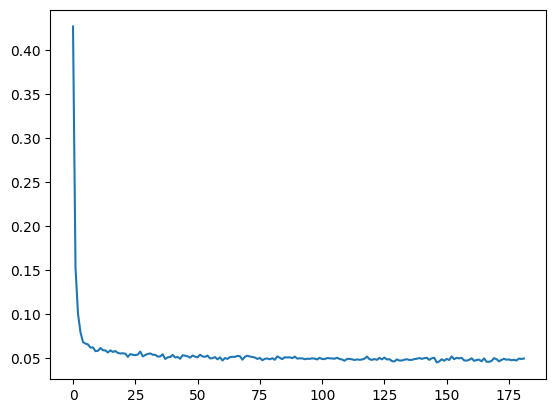

In [24]:
# Plot the loss values over the training steps
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Evaluate the trained CF model on the test set by computing the Mean Squared Error (MSE) of the model's predictions

In [25]:
# Evaluate the model on the validation set using Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

# Set the model to evaluation mode
model.eval()

# Iterate over the batches of data in the validation dataset
with torch.no_grad():  # disable gradient calculation to save memory and computation
    for i, batched_data in enumerate(validation_loader):

        # Perform inference on the model for a data batch to get predicted ratings
        model_output = model(batched_data['users'],
                             batched_data['movies'])

        # Computes average predicted rating for the batch and appends to list
        model_output_list.append(model_output.sum().item() / len(batched_data['users']))

        # Computes average actual rating for the batch and appends to list
        target_rating = batched_data['ratings']
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        # Print the model output and target rating for the batch
        print(f'model_output: {model_output}, target_rating: {target_rating}')

# Calculate the mean squared error between the predicted and actual ratings
rms = mean_squared_error(target_rating_list, model_output_list)
print(f'rms: {rms}')

model_output: tensor([[3.4491],
        [4.8613],
        [2.5066],
        [2.4669]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[2.6563],
        [3.5485],
        [2.8780],
        [3.5572]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[3.3912],
        [3.8989],
        [1.5050],
        [4.3490]]), target_rating: tensor([3, 3, 0, 3])
model_output: tensor([[3.3212],
        [3.2434],
        [2.2903],
        [2.6403]]), target_rating: tensor([2, 4, 2, 1])
model_output: tensor([[3.3601],
        [2.3649],
        [3.7073],
        [2.4403]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[2.9030],
        [4.6024],
        [3.5503],
        [2.7889]]), target_rating: tensor([2, 5, 4, 4])
model_output: tensor([[3.5805],
        [3.2046],
        [3.7799],
        [4.6046]]), target_rating: tensor([1, 3, 4, 5])
model_output: tensor([[3.1726],
        [3.9220],
        [2.7804],
        [4.2454]]), target_rating: tensor([3, 5, 2, 4])
model_ou

### Evaluate model on validation dataset and build dictionary of predicted to actual ratings for each user

In [26]:
from collections import defaultdict

# Create a dictionary to store the predicted movie rating and actual movie 
# rating for each user
user_est_true = defaultdict(list)

# Iterate through the validation dataset to build the 
# user-> [(y1, y1_hat), (y2, y2_hat)] dictionary
with torch.no_grad():  # disable gradient calculation to save memory and computation
    # Iterate over the batches of data in the validation dataset
    for i, batched_data in enumerate(validation_loader):  
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']

        # Perform inference on the model for a data batch to get predicted ratings
        model_output = model(batched_data['users'],
                             batched_data['movies'])

        # Build dictionary of user_id => [(y1, y1_hat), (y2, y2_hat)]
        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            # Print user_id, movie_id, predicted rating, and actual rating for the batch
            print(f'user_id: {user_id}, movie_id: {movie_id}, pred_rating: {pred_rating}, true_rating: {true_rating}')

            # Append the predicted and actual ratings to the user_est_true dictionary
            user_est_true[user_id].append((pred_rating, true_rating))


user_id: 67, movie_id: 6534, pred_rating: 3.3399152755737305, true_rating: 5
user_id: 579, movie_id: 3844, pred_rating: 2.7481040954589844, true_rating: 3
user_id: 287, movie_id: 2345, pred_rating: 3.7199344635009766, true_rating: 3
user_id: 51, movie_id: 5780, pred_rating: 3.5960278511047363, true_rating: 3
user_id: 607, movie_id: 5366, pred_rating: 2.684739351272583, true_rating: 4
user_id: 524, movie_id: 43, pred_rating: 3.6490859985351562, true_rating: 3
user_id: 190, movie_id: 433, pred_rating: 3.570000171661377, true_rating: 5
user_id: 155, movie_id: 823, pred_rating: 3.581540822982788, true_rating: 5
user_id: 131, movie_id: 5999, pred_rating: 3.3742122650146484, true_rating: 2
user_id: 607, movie_id: 2473, pred_rating: 3.490490674972534, true_rating: 4
user_id: 496, movie_id: 659, pred_rating: 3.737138032913208, true_rating: 4
user_id: 609, movie_id: 2603, pred_rating: 3.5656628608703613, true_rating: 2
user_id: 176, movie_id: 505, pred_rating: 3.355700969696045, true_rating: 3


### Calculate Precision@K and Recall@K for each user based on predicted and actual ratings stored in the dictionary

In [27]:
with torch.no_grad():  # disable gradient calculation to save memory and computation
    # Empty dicts to store precision and recall values
    precisions = dict()
    recalls = dict()

    # Top recommendations to consider
    k = 100

    # Threshold for considering a rating as relevant
    # (equal or above considered relevant)
    threshold = 3.5

    # Iterate over the users and ratings stored in user_est_true dictionary
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value (highest first)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Print intermediate results
        print(f'uid {uid}, n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}')


        # Calculate Precision@K for the user - proportion of recommended items 
        # that are relevant. If n_rec_k is 0, set precision to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Calculate Recall@K for the user - proportion of relevant items 
        # that are recommended. If n_rel is 0, set recall to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0


uid 67, n_rel 34, n_rec_k 18, n_rel_and_rec_k 6
uid 579, n_rel 25, n_rec_k 22, n_rel_and_rec_k 17
uid 287, n_rel 27, n_rec_k 25, n_rel_and_rec_k 12
uid 51, n_rel 10, n_rec_k 11, n_rel_and_rec_k 10
uid 607, n_rel 36, n_rec_k 8, n_rel_and_rec_k 6
uid 524, n_rel 16, n_rec_k 12, n_rel_and_rec_k 6
uid 190, n_rel 7, n_rec_k 10, n_rel_and_rec_k 7
uid 155, n_rel 24, n_rec_k 21, n_rel_and_rec_k 17
uid 131, n_rel 6, n_rec_k 0, n_rel_and_rec_k 0
uid 496, n_rel 3, n_rec_k 1, n_rel_and_rec_k 1
uid 609, n_rel 56, n_rec_k 78, n_rel_and_rec_k 44
uid 176, n_rel 34, n_rec_k 31, n_rel_and_rec_k 18
uid 186, n_rel 19, n_rec_k 8, n_rel_and_rec_k 6
uid 236, n_rel 2, n_rec_k 3, n_rel_and_rec_k 2
uid 588, n_rel 4, n_rec_k 6, n_rel_and_rec_k 4
uid 104, n_rel 46, n_rec_k 47, n_rel_and_rec_k 35
uid 380, n_rel 20, n_rec_k 10, n_rel_and_rec_k 6
uid 312, n_rel 18, n_rec_k 13, n_rel_and_rec_k 9
uid 447, n_rel 51, n_rec_k 8, n_rel_and_rec_k 7
uid 88, n_rel 25, n_rec_k 8, n_rel_and_rec_k 0
uid 602, n_rel 57, n_rec_k 50

### Calculate the Average Precision@K and Average Recall@K for all users

In [28]:
# Precision and recall averaged over all users
print(f'Precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}')

print(f'Recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}')

Precision @ 100: 0.5834012610507838
Recall @ 100: 0.5771013659150727


### Recommend the top K movies for a given user

In [31]:
df_movies = pd.read_csv('../Sandbox/MovieLens/ml-latest-small/movies.csv')

In [32]:
# Rename items to be consistent with the inference notebook code
lbl_movie_loaded = lbl_movie
lbl_user_loaded = lbl_user
model_loaded = model

In [33]:
# Assuming the model is already defined and trained
# model = RecSysModel(n_users, n_movies, n_factors)


def recommend_movies_for_new_user(model, user_ids, movie_ids, top_k=10):
    # Get all movie ids
    movie_ids = torch.LongTensor(range(len(lbl_movie_loaded.classes_)))
    print(f'movie_ids device: {movie_ids.device}')
    print(f'movie_ids: {movie_ids}')
    # Use a placeholder user id (e.g., 0)
    user_id = 0
    user_ids = torch.LongTensor([user_id] * len(lbl_movie_loaded.classes_))
    print(f'user_ids device: {user_ids.device}')
    print(f'user_ids: {user_ids}')
    # Get predictions for all movies
    with torch.no_grad():
        all_predictions = model(user_ids, movie_ids)
        print()
        print(f'all_predictions device: {all_predictions.device}')
        print(f"all_predictions shape: {all_predictions.shape}")
        print(f'all_predictions: {all_predictions}')
    # Ensure top_k does not exceed the number of available movies
    top_k = min(top_k, len(all_predictions))
    print()
    print(f'top_k: {top_k}')
    print(f'len(all_predictions): {len(all_predictions)}')
    # Get top k movie predictions
    # top_k_predictions, top_k_indices = all_predictions.topk(top_k)
    top_k_predictions, top_k_indices = torch.topk(all_predictions, top_k, dim=0, largest=True, sorted=True)
    print()
    print(f'top_k_predictions device: {top_k_predictions.device}')
    print(f'top_k_predictions: {top_k_predictions}')
    print(f'top_k_indices device: {top_k_indices.device}')
    print(f'top_k_indices: {top_k_indices}')
    return top_k_predictions, top_k_indices


### Define ratings for a new user and generate recommendations

In [34]:
# Define ratings for a new user to be used for recommendations
#new_user_ratings = {
#    'movieId': [2959, 318, 1213, 1221, 858, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Example movie IDs
#    'rating': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   # Example ratings
#}

new_user_ratings = {
    'movieId': [4896, 5816, 8368, 40815, 54001, 69844, 318], # Harry Potter Movies
    'rating': [5, 5, 5, 5, 5, 5, 0]
}

# Convert the new user ratings to a DataFrame
df_new_user_ratings = pd.DataFrame(new_user_ratings)
print(f'MovieId df_new_user_ratings.head(): {df_new_user_ratings.head()}')
# Encode the movie IDs using the loaded label encoder
df_new_user_ratings['movieId'] = lbl_movie_loaded.transform(df_new_user_ratings['movieId'])
print(f'Movie_label df_new_user_ratings.head(): {df_new_user_ratings.head()}')

# Encode the user ID using the loaded label encoder
user_id = 0  # Placeholder user ID

# Add unseen user_id to lbl_user_loaded
if user_id not in lbl_user_loaded.classes_:
    lbl_user_loaded.classes_ = np.append(lbl_user_loaded.classes_, user_id)

df_new_user_ratings['userId'] = lbl_user_loaded.transform([user_id] * len(df_new_user_ratings))
# print(f'df_new_user_ratings: {df_new_user_ratings}')

# Convert the DataFrame to tensors
user_tensor = torch.LongTensor(df_new_user_ratings['userId'].values)
print(f'user_tensor: {user_tensor}')
movie_tensor = torch.LongTensor(df_new_user_ratings['movieId'].values)
print(f'movie_tensor: {movie_tensor}')
# Convert ratings to tensor
ratings_tensor = torch.FloatTensor(df_new_user_ratings['rating'].values)
print(f'ratings_tensor: {ratings_tensor}')

# Get recommendations for the new user by passing the user and movie tensors to the model
top_k_predictions, top_k_indices = recommend_movies_for_new_user(model_loaded, user_tensor, movie_tensor, top_k=100)
print(f'top_k_predictions: {top_k_predictions}')
print(f'top_k_indices: {top_k_indices}')

# Convert top_k_indices to movie IDs
top_k_movie_ids = lbl_movie_loaded.inverse_transform(top_k_indices.numpy())
print(f'top_k_movie_ids: {top_k_movie_ids}')

# Ensure the top_k_movie_ids and top_k_predictions are 1D tensors
print(f"top_k_movie_ids shape: {top_k_movie_ids.shape}")
print(f"top_k_predictions shape: {top_k_predictions.shape}")
top_k_movie_ids = top_k_movie_ids.flatten() if len(top_k_movie_ids.shape) > 1 else top_k_movie_ids
top_k_predictions = top_k_predictions.flatten() if len(top_k_predictions.shape) > 1 else top_k_predictions
print(f"top_k_movie_ids shape: {top_k_movie_ids.shape}")
print(f"top_k_predictions shape: {top_k_predictions.shape}")

# Convert top_k_movie_ids to DataFrame
df_recommendations = pd.DataFrame({
    'movieId': top_k_movie_ids,
    'predicted_rating': top_k_predictions.numpy()
})
print(f'df_recommendations: {df_recommendations}')
# Merge with movie titles
df_recommendations = df_recommendations.merge(df_movies, on='movieId', how='left')
print(f'df_recommendations: {df_recommendations}')

MovieId df_new_user_ratings.head():    movieId  rating
0     4896       5
1     5816       5
2     8368       5
3    40815       5
4    54001       5
Movie_label df_new_user_ratings.head():    movieId  rating
0     3569       5
1     4070       5
2     5156       5
3     6045       5
4     6505       5
user_tensor: tensor([0, 0, 0, 0, 0, 0, 0])
movie_tensor: tensor([3569, 4070, 5156, 6045, 6505, 7061,  277])
ratings_tensor: tensor([5., 5., 5., 5., 5., 5., 0.])
movie_ids device: cpu
movie_ids: tensor([   0,    1,    2,  ..., 9721, 9722, 9723])
user_ids device: cpu
user_ids: tensor([0, 0, 0,  ..., 0, 0, 0])

all_predictions device: cpu
all_predictions shape: torch.Size([9724, 1])
all_predictions: tensor([[4.5570],
        [4.1197],
        [4.0453],
        ...,
        [3.8376],
        [3.8039],
        [4.1474]])

top_k: 100
len(all_predictions): 9724

top_k_predictions device: cpu
top_k_predictions: tensor([[5.4748],
        [5.4216],
        [5.4103],
        [5.3882],
        [5.38

/home/mbuhidar/Code/mbuhidar/movie_recommender_system_app/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Display the top-k recommended movies

In [35]:
# Display the top-k recommended movies
# Show all rows and columns in a Jupyter Notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("Top-k recommended movies:")
print(df_recommendations[['movieId', 'title', 'predicted_rating']].head(20))
# df_recommendations

Top-k recommended movies:
    movieId                                              title  \
0      3201                            Five Easy Pieces (1970)   
1      8477                                   Jetée, La (1962)   
2      3451                Guess Who's Coming to Dinner (1967)   
3     27397  Joint Security Area (Gongdong gyeongbi guyeok ...   
4      1248                               Touch of Evil (1958)   
5      2239  Swept Away (Travolti da un insolito destino ne...   
6     92535      Louis C.K.: Live at the Beacon Theater (2011)   
7      1217                                         Ran (1985)   
8     93838                        The Raid: Redemption (2011)   
9      7983                         Broadway Danny Rose (1984)   
10    55167           Tekkonkinkreet (Tekkon kinkurîto) (2006)   
11     6666  Discreet Charm of the Bourgeoisie, The (Charme...   
12     1208                              Apocalypse Now (1979)   
13     1046                             Beautiful 